In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tabulate import tabulate
import re
def channel2Energie(c):
    return c * 0.0013902686264571718;

In [2]:

folder_path = "data/210417_Halbleiter/spannungen_detektor"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.TKA')]

data = {}

for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    file_data = np.loadtxt(file_path, delimiter=',', skiprows=2)
    data[int(csv_file.replace('.TKA', ''))] = file_data


In [3]:
def gauss_function(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def gauss_fit(data, ax, voltage):
    data_scale = data / np.sum(data)
    #threshold = 0.004
    #width = 150
    #above_threshold = np.where(data_scale > threshold)[0]
    fit_start = 0#above_threshold[0] - width
    fit_end = len(data) #above_threshold[-1] + width
    channels =  np.arange(2, len(data) + 2)
    energies = channel2Energie(channels)
    p0 = [data_scale[fit_start:fit_end].max(), energies[data_scale.argmax()], channel2Energie(fit_end-fit_start)]
    coeff, _ = curve_fit(gauss_function, energies[fit_start:fit_end], data_scale[fit_start:fit_end], p0=p0)
    ax.scatter(energies, data_scale, 0.9, marker='.')
    ax.plot(energies[fit_start:fit_end], gauss_function(energies[fit_start:fit_end], *coeff),'r--' ,label= f'{voltage}V')
    #ax.set_xticks(list(ax.get_xticks()) + [round(coeff[1])])
    return coeff

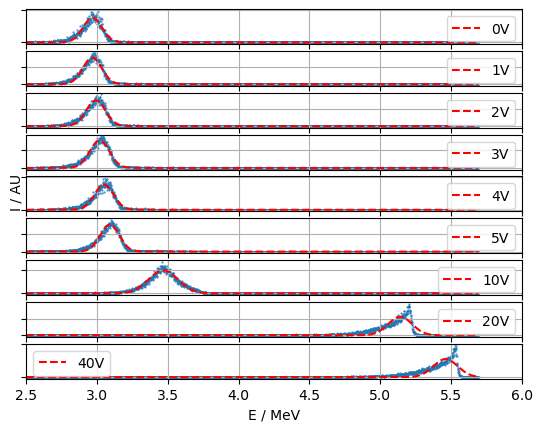

In [6]:
fig, ax = plt.subplots(len(data), 1, sharex=True)
max_channels = []
coeff_table = []
for i, d in enumerate(sorted(data.keys())):
    dat = data[d]
    coeff = gauss_fit(dat, ax[i], d)
    coeff_table.append( np.concatenate(([d], coeff)))
    ax[i].set_yticklabels([])
    ax[i].grid()
    ax[i].legend()
    ax[i].set(xlim=[2.5,6])


ax[-1].set(xlabel="E / MeV")
fig.text(0.10, 0.5, 'I / AU', va='center', rotation='vertical')
fig.savefig("out/alpha_pulse_width.png")


In [5]:
table = tabulate(coeff_table, headers=["$U / \mathrm{V}$", "$a$","$\\mu$", "\\sigma" ], tablefmt='latex')

def convert2LatexString(s):
    r = r'(\^\{\})'; s = re.sub(r, "^", s)
    s = re.sub(r'\\([\$\_\{\}\^])', r'\1', s)
    s = re.sub(r'(\\textbackslash{})', r'\\', s)
    return s

# Tabelle in eine Datei schreiben
with open('out/test.tex', 'w') as f:
    f.write(convert2LatexString(table))
